# Accelerate Your Customer 360 Journey with MongoDB vCore on Azure

#### Unify customer data. Unlock insights. Deploy AI.

### 1. What Is It?
- The MongoDB vCore Customer 360 Solution Accelerator is a ready-to-deploy reference implementation that showcases how to build a modern, intelligent customer data platform using MongoDB vCore on Azure Cosmos DB. 

### 2. Who Is It For?
- Banks and financial institutions modernizing legacy systems
- Teams migrating from on-prem MongoDB or MongoDB Atlas
- Architects exploring AI, RAG, and real-time analytics use cases

### 3. What’s Included?
- Sample Customer 360 schema and data
- Aggregation pipelines 
- Graph lookups
- Power BI dashboards for real-time insights
- Vector search + RAG integration with Azure OpenAI

### 4. Why Use This Accelerator?
- Try before you build: Explore MongoDB vCore capabilities in a sandboxed Azure environment
- Accelerate time-to-value: Use pre-built components to jumpstart your implementation
- Showcase to stakeholders: Demonstrate real-world use cases like segmentation, fraud detection, and intelligent assistants

Author: Srikanth Sridhar, Microsoft, Global Black Belt (GBB) - Azure Databases

## Setup

This notebook uses a Python virtual environment.

Please refer to this link to create python environments in VS Code, [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments)

• Refer to the requirements.txt file for required libraries.

• This demo uses Mongo vCore M30 cluster setup, please ensure you've created a Mongo vCore cluster on Azure before running this notebook.

• Ensure proper permissions to write input files, and create a .env file for the credentials required.

In [129]:
from faker import Faker
import random
import pandas as pd
import os
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote_plus
import networkx as nx

env_name = "./config/config.env" # using config.env template, change to your own .env file name
config = dotenv_values(env_name)

connection_string = config['vCORE_CONN_STRING']
cust_file_path = "./data/customers.csv"
bank_trans_file_path = "./data/customer_bank_transactions.csv"
cc_trans_file_path = "./data/customer_credit_card_transactions.csv"
db_name = "customer360"

## Generate Sample C360 Data with Bank and Credit Card Transactions

In [130]:
def format_elapsed_time(elapsed_seconds):
    hours, remainder = divmod(elapsed_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{seconds:05.2f}"

start_time = datetime.now()

fake = Faker()
Faker.seed(0)
random.seed(0)

# Generate synthetic customer profiles
def generate_customers(num_customers):
    customers = []
    for i in range(num_customers):
        customer_id = f"C{1000 + i}"
        customers.append({
            "customer_id": customer_id,
            "name": fake.name(),
            "email": fake.email(),
            "phone": fake.phone_number(),
            "address": fake.address().replace("\n", ", "),
            "dob": fake.date_of_birth(minimum_age=18, maximum_age=80).strftime("%Y-%m-%d"),
            "account_open_date": fake.date_between(start_date='-10y', end_date='today').strftime("%Y-%m-%d")
        })
    return customers

# Generate synthetic bank transactions
def generate_bank_transactions(customers, num_transactions):
    transactions = []
    transaction_types = ["deposit", "withdrawal", "transfer"]
    for i in range(num_transactions):
        customer = random.choice(customers)
        transactions.append({
            "transaction_id": f"B{10000 + i}",
            "customer_id": customer["customer_id"],
            "date": fake.date_between(start_date='-2y', end_date='today').strftime("%Y-%m-%d"),
            "type": random.choice(transaction_types),
            "amount": round(random.uniform(50, 5000), 2),
            "description": fake.sentence()
        })
    return transactions

# Generate synthetic credit card transactions
def generate_credit_card_transactions(customers, num_transactions):
    transactions = []
    categories = ["groceries", "travel", "electronics", "restaurants", "clothing", "utilities"]
    for i in range(num_transactions):
        customer = random.choice(customers)
        transactions.append({
            "transaction_id": f"CC{20000 + i}",
            "customer_id": customer["customer_id"],
            "date": fake.date_between(start_date='-2y', end_date='today').strftime("%Y-%m-%d"),
            "merchant": fake.company(),
            "category": random.choice(categories),
            "amount": round(random.uniform(10, 2000), 2),
            "description": fake.sentence()
        })
    return transactions

# Generate and save datasets
num_customers = 100
num_bank_transactions = 500
num_credit_card_transactions = 500

customers = generate_customers(num_customers)
bank_transactions = generate_bank_transactions(customers, num_bank_transactions)
credit_card_transactions = generate_credit_card_transactions(customers, num_credit_card_transactions)

# Ensure the directory exists if not create it
os.makedirs(os.path.dirname(cust_file_path), exist_ok=True)

os.makedirs(os.path.dirname(bank_trans_file_path), exist_ok=True)

os.makedirs(os.path.dirname(cc_trans_file_path), exist_ok=True)

pd.DataFrame(customers).to_csv(cust_file_path, index=False)
pd.DataFrame(bank_transactions).to_csv(bank_trans_file_path, index=False)
pd.DataFrame(credit_card_transactions).to_csv(cc_trans_file_path, index=False)

print("Synthetic datasets saved as CSV files.")

end_time = datetime.now()
print(f"Generated customer transactions and saved to {cust_file_path, bank_trans_file_path, cc_trans_file_path}")

elapsed_time = end_time - start_time
elapsed_time_str = format_elapsed_time(elapsed_time.total_seconds())
print(f"Total time taken to generate the input file HH:MM:SS: {elapsed_time_str}")

Synthetic datasets saved as CSV files.
Generated customer transactions and saved to ('./data/customers.csv', './data/customer_bank_transactions.csv', './data/customer_credit_card_transactions.csv')
Total time taken to generate the input file HH:MM:SS: 00:00:00.35


## Ingest Data into MongoDB

In [131]:
# Replace with your MongoDB vCore connection string
client = MongoClient(connection_string)
client.drop_database(db_name) #drop if DB exists and recreate
db = client[db_name]

# Load CSVs
customers_df = pd.read_csv(cust_file_path)
bank_tx_df = pd.read_csv(bank_trans_file_path)
cc_tx_df = pd.read_csv(cc_trans_file_path)

start_time = datetime.now()
# Insert into MongoDB, provide the respective collection names
db.customers.insert_many(customers_df.to_dict(orient="records"))
db.customer_bank_trans.insert_many(bank_tx_df.to_dict(orient="records"))
db.customer_card_trans.insert_many(cc_tx_df.to_dict(orient="records"))

end_time = datetime.now()
elapsed_time = end_time - start_time
elapsed_time_str = format_elapsed_time(elapsed_time.total_seconds())
print(f"Total time taken to insert the input files to Mongo vCore collections, HH:MM:SS: {elapsed_time_str}")


C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\1496522355.py:2: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(connection_string)


Total time taken to insert the input files to Mongo vCore collections, HH:MM:SS: 00:00:00.38


## Build various aggregation query pipelines
### # 1. Customers with accounts older than 5 years

In [132]:
from pprint import pprint
from datetime import datetime, UTC

now = datetime.now(UTC)

# 1. Customers with accounts older than 5 years
print("\n1. Customers with accounts older than 5 years:")
result1 = db.customers.aggregate([
    {
        "$addFields": {
            "account_open_date_dt": {
                "$cond": {
                    "if": { "$eq": [{ "$type": "$account_open_date" }, "string"] },
                    "then": { "$dateFromString": { "dateString": "$account_open_date" } },
                    "else": "$account_open_date"
                }
            }
        }
    },
    {
        "$addFields": {
            "account_age": {
                "$divide": [
                    { "$subtract": [now, "$account_open_date_dt"] },
                    1000 * 60 * 60 * 24 * 365  # Convert milliseconds to years
                ]
            }
        }
    },
    {
        "$match": {
            "account_age": { "$gt": 5 }
        }
    },
    {
        "$sort": { "account_age": -1 }
    },
    {
        "$limit": 5
    }
])
pprint(list(result1))


1. Customers with accounts older than 5 years:
[{'_id': ObjectId('68b7e0cbd3af4963f6ce08a2'),
  'account_age': 9.924032834665145,
  'account_open_date': '2015-10-04',
  'account_open_date_dt': datetime.datetime(2015, 10, 4, 0, 0),
  'address': '20298 Adrian Wall Suite 897, South Anitamouth, VI 13284',
  'customer_id': 'C1043',
  'dob': '1991-05-04',
  'email': 'melissa27@example.org',
  'name': 'David Diaz',
  'phone': '576-396-8147'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0896'),
  'account_age': 9.822662971651447,
  'account_open_date': '2015-11-10',
  'account_open_date_dt': datetime.datetime(2015, 11, 10, 0, 0),
  'address': '27166 King Throughway, Chelsealand, ME 04450',
  'customer_id': 'C1031',
  'dob': '1978-03-10',
  'email': 'rachelcox@example.org',
  'name': 'Andrew Gaines',
  'phone': '+1-535-970-3934x26197'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce089a'),
  'account_age': 9.77882735521309,
  'account_open_date': '2015-11-26',
  'account_open_date_dt': datetime.datetime(2

### 2. Credit card transactions over $300 in groceries


In [133]:
# 2. Credit card transactions over $300 in groceries
print("\n2. Credit card transactions over $300 in groceries:")
result2 = db.customer_card_trans.aggregate([
    {
        "$match": {
            "amount": { "$gt": 300 },
            "category": "groceries"
        }
    }, { "$limit": 5 }

])
pprint(list(result2))


2. Credit card transactions over $300 in groceries:
[{'_id': ObjectId('68b7e0cbd3af4963f6ce0acf'),
  'amount': 393.85,
  'category': 'groceries',
  'customer_id': 'C1040',
  'date': '2024-12-28',
  'description': 'Everybody always response long star street line.',
  'merchant': 'Adams, Mason and Bauer',
  'transaction_id': 'CC20000'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0adb'),
  'amount': 833.53,
  'category': 'groceries',
  'customer_id': 'C1024',
  'date': '2024-12-24',
  'description': 'Present guy community already leader.',
  'merchant': 'Delgado-Edwards',
  'transaction_id': 'CC20012'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0add'),
  'amount': 1204.89,
  'category': 'groceries',
  'customer_id': 'C1049',
  'date': '2025-06-22',
  'description': 'Write pattern concern toward fast spring produce general.',
  'merchant': 'Jackson-Barnes',
  'transaction_id': 'CC20014'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0aea'),
  'amount': 1075.87,
  'category': 'groceries',
  'customer_i

### 3. Bank withdrawals over $200

In [134]:
# 3. Bank withdrawals over $200
print("\n3. Bank withdrawals over $200:")
result3 = db.customer_bank_trans.aggregate([
    {
        "$match": {
            "type": "withdrawal",
            "amount": { "$gt": 200 }
        }
    }, { "$limit": 5 }
])
pprint(list(result3))


3. Bank withdrawals over $200:
[{'_id': ObjectId('68b7e0cbd3af4963f6ce08db'),
  'amount': 250.4,
  'customer_id': 'C1049',
  'date': '2024-08-12',
  'description': 'Expert cell style believe tough wait candidate under.',
  'transaction_id': 'B10000',
  'type': 'withdrawal'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce08dc'),
  'amount': 2054.42,
  'customer_id': 'C1065',
  'date': '2024-03-27',
  'description': 'Society foot knowledge report national.',
  'transaction_id': 'B10001',
  'type': 'withdrawal'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce08dd'),
  'amount': 1822.34,
  'customer_id': 'C1038',
  'date': '2025-04-11',
  'description': 'How artist gas this.',
  'transaction_id': 'B10002',
  'type': 'withdrawal'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce08e3'),
  'amount': 2387.11,
  'customer_id': 'C1087',
  'date': '2024-05-15',
  'description': 'Parent majority know participant traditional.',
  'transaction_id': 'B10008',
  'type': 'withdrawal'},
 {'_id': ObjectId('68b7e0cbd3af4963f6

### 4. Group transactions by customer and count

In [135]:
# 4. Group transactions by customer and count
print("\n4. Group transactions by customer and count:")
result4 = db.customer_bank_trans.aggregate([
    {
        "$group": {
            "_id": "$customer_id",
            "total_transactions": { "$sum": 1 },
            "total_amount": { "$sum": "$amount" }
        }
    },
    {
        "$sort": { "total_amount": -1 }
    }, { "$limit": 5 }
])
pprint(list(result4))


4. Group transactions by customer and count:
[{'_id': 'C1089', 'total_amount': 33785.5, 'total_transactions': 13},
 {'_id': 'C1010', 'total_amount': 29838.839999999997, 'total_transactions': 9},
 {'_id': 'C1032', 'total_amount': 27790.07, 'total_transactions': 9},
 {'_id': 'C1077', 'total_amount': 25284.95, 'total_transactions': 11},
 {'_id': 'C1016', 'total_amount': 24754.550000000003, 'total_transactions': 10}]


### 5. Monthly spending summary for credit cards

In [136]:
# 5. Monthly spending summary for credit cards
print("\n5. Monthly spending summary for credit cards:")
result5 = db.customer_card_trans.aggregate([
    {
        "$addFields": {
            "month": { "$month": { "$dateFromString": { "dateString": "$date" } } },
            "year": { "$year": { "$dateFromString": { "dateString": "$date" } } }
        }
    },
    {
        "$group": {
            "_id": { "year": "$year", "month": "$month" },
            "total_spent": { "$sum": "$amount" },
            "transaction_count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id.year": -1, "_id.month": -1 }
    }
    , 
    { "$limit": 5 }
])
pprint(list(result5))


5. Monthly spending summary for credit cards:
[{'_id': {'month': 8, 'year': 2025},
  'total_spent': 33539.78999999999,
  'transaction_count': 29},
 {'_id': {'month': 7, 'year': 2025},
  'total_spent': 23149.31,
  'transaction_count': 21},
 {'_id': {'month': 6, 'year': 2025},
  'total_spent': 21405.180000000008,
  'transaction_count': 19},
 {'_id': {'month': 5, 'year': 2025},
  'total_spent': 20796.819999999996,
  'transaction_count': 22},
 {'_id': {'month': 4, 'year': 2025},
  'total_spent': 25911.329999999994,
  'transaction_count': 28}]


### 6. Join customers with their transactions using $lookup

In [137]:
# 6. Join customers with their transactions using $lookup
print("\n6. Join customers with their transactions using $lookup:")
result6 = db.customers.aggregate([
    {
        "$lookup": {
            "from": "bank_transactions",
            "localField": "customer_id",
            "foreignField": "customer_id",
            "as": "bank_txns"
        }
    },
    {
        "$lookup": {
            "from": "credit_card_transactions",
            "localField": "customer_id",
            "foreignField": "customer_id",
            "as": "credit_txns"
        }
    }
    , { "$limit": 5 }
])
pprint(list(result6))


6. Join customers with their transactions using $lookup:
[{'_id': ObjectId('68b7e0cbd3af4963f6ce0877'),
  'account_open_date': '2016-09-23',
  'address': '578 Michael Island, New Thomas, VI 68835',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1000',
  'dob': '1962-05-26',
  'email': 'tammy76@example.com',
  'name': 'Norma Fisher',
  'phone': '459.638.2421x9489'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0878'),
  'account_open_date': '2020-08-11',
  'address': '714 Mann Plaza Suite 839, Seanfurt, MD 75952',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1001',
  'dob': '1961-02-23',
  'email': 'ypage@example.net',
  'name': 'Kimberly Smith',
  'phone': '+1-909-375-3513x9332'},
 {'_id': ObjectId('68b7e0cbd3af4963f6ce0879'),
  'account_open_date': '2018-02-28',
  'address': '59179 Bruce Gardens Apt. 413, Lauramouth, NE 08652',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1002',
  'dob': '1951-07-09',
  'email': 'thomas12@example.org',
  'name': 'Rob

## Use $graphLookup feature traversal for Credit Card and Bank Transactions

In [138]:
# Define the sample customer_id
sample_customer_id = "C1001"  # Replace with a valid customer_id from your dataset

# Graph lookup pipeline to retrieve both credit card and bank transactions
pipeline = [
    {
        "$match": {"customer_id": sample_customer_id}
    },
    {
        "$graphLookup": {
            "from": "customer_card_trans",
            "startWith": "$customer_id",
            "connectFromField": "customer_id",
            "connectToField": "customer_id",
            "as": "related_credit_card_transactions"
        }
    },
    {
        "$graphLookup": {
            "from": "customer_bank_trans",
            "startWith": "$customer_id",
            "connectFromField": "customer_id",
            "connectToField": "customer_id",
            "as": "related_bank_transactions"
        }
    },
    {
        "$project": {
            "customer_id": 1,
            "name": 1,
            "related_credit_card_transactions": 1,
            "related_bank_transactions": 1
        }
    }
]

# Execute the aggregation
graph_result = list(db.customers.aggregate(pipeline))

# Print results
if graph_result:
    print(f"🔍 Related credit card transactions for customer {sample_customer_id}:")
    for txn in graph_result[0]["related_credit_card_transactions"]:
        print(txn)

    print(f"\n🏦 Related bank transactions for customer {sample_customer_id}:")
    for txn in graph_result[0]["related_bank_transactions"]:
        print(txn)
else:
    print(f"❌ No customer found with ID {sample_customer_id}")

🔍 Related credit card transactions for customer C1001:
{'_id': ObjectId('68b7e0cbd3af4963f6ce0b5c'), 'transaction_id': 'CC20141', 'customer_id': 'C1001', 'date': '2025-06-19', 'merchant': 'Hickman-Morse', 'category': 'restaurants', 'amount': 716.18, 'description': 'Laugh class paper base arm computer garden.'}
{'_id': ObjectId('68b7e0cbd3af4963f6ce0bbf'), 'transaction_id': 'CC20240', 'customer_id': 'C1001', 'date': '2025-04-24', 'merchant': 'Gomez, Thompson and Johnson', 'category': 'travel', 'amount': 844.49, 'description': 'Remain so expert southern ball.'}
{'_id': ObjectId('68b7e0cbd3af4963f6ce0be8'), 'transaction_id': 'CC20281', 'customer_id': 'C1001', 'date': '2025-08-09', 'merchant': 'Garcia-Hamilton', 'category': 'electronics', 'amount': 1608.66, 'description': 'Mr forget involve well interest.'}
{'_id': ObjectId('68b7e0cbd3af4963f6ce0bff'), 'transaction_id': 'CC20304', 'customer_id': 'C1001', 'date': '2023-10-15', 'merchant': 'Flores-Gross', 'category': 'electronics', 'amount':

## Graph Visualization using Python libraries, similar approach can be used on other Graph Visualization tools

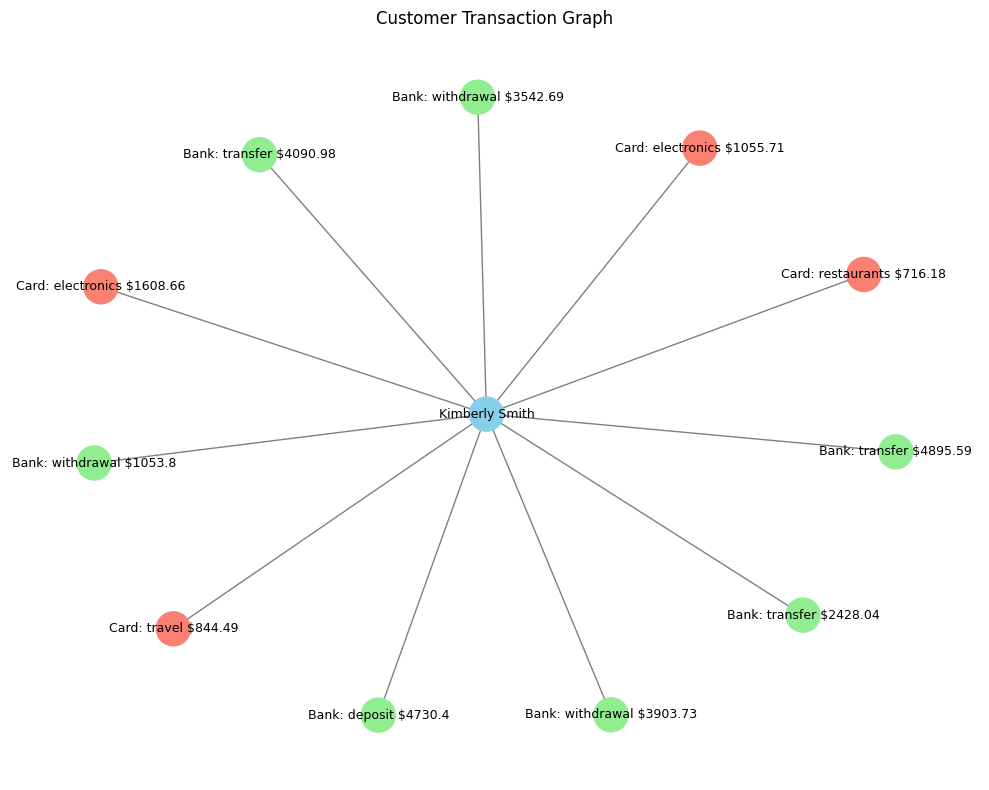

In [139]:
# Create graph
G = nx.Graph()

# print(graph_result)
customer_data = graph_result[0]

# Add customer node
customer_id = customer_data["customer_id"]
customer_name = customer_data["name"]
G.add_node(customer_id, label=customer_name, type="customer")

# Add credit card transaction nodes and edges
for tx in customer_data["related_credit_card_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Card: {tx['category']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="credit_card_tx")
    G.add_edge(customer_id, tx_id)

# Add bank transaction nodes and edges
for tx in customer_data["related_bank_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Bank: {tx['type']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="bank_tx")
    G.add_edge(customer_id, tx_id)

# Draw graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Assign colors based on node type
node_colors = []
for node, data in G.nodes(data=True):
    if data["type"] == "customer":
        node_colors.append("skyblue")
    elif data["type"] == "bank_tx":
        node_colors.append("lightgreen")
    else:
        node_colors.append("salmon")

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
labels = {node: data["label"] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Customer Transaction Graph")
plt.axis("off")
plt.tight_layout()
plt.show()

## Graph Visualization of Customer Transactions
### Customers → Transactions → Merchants
### Customers → Transactions → Categories

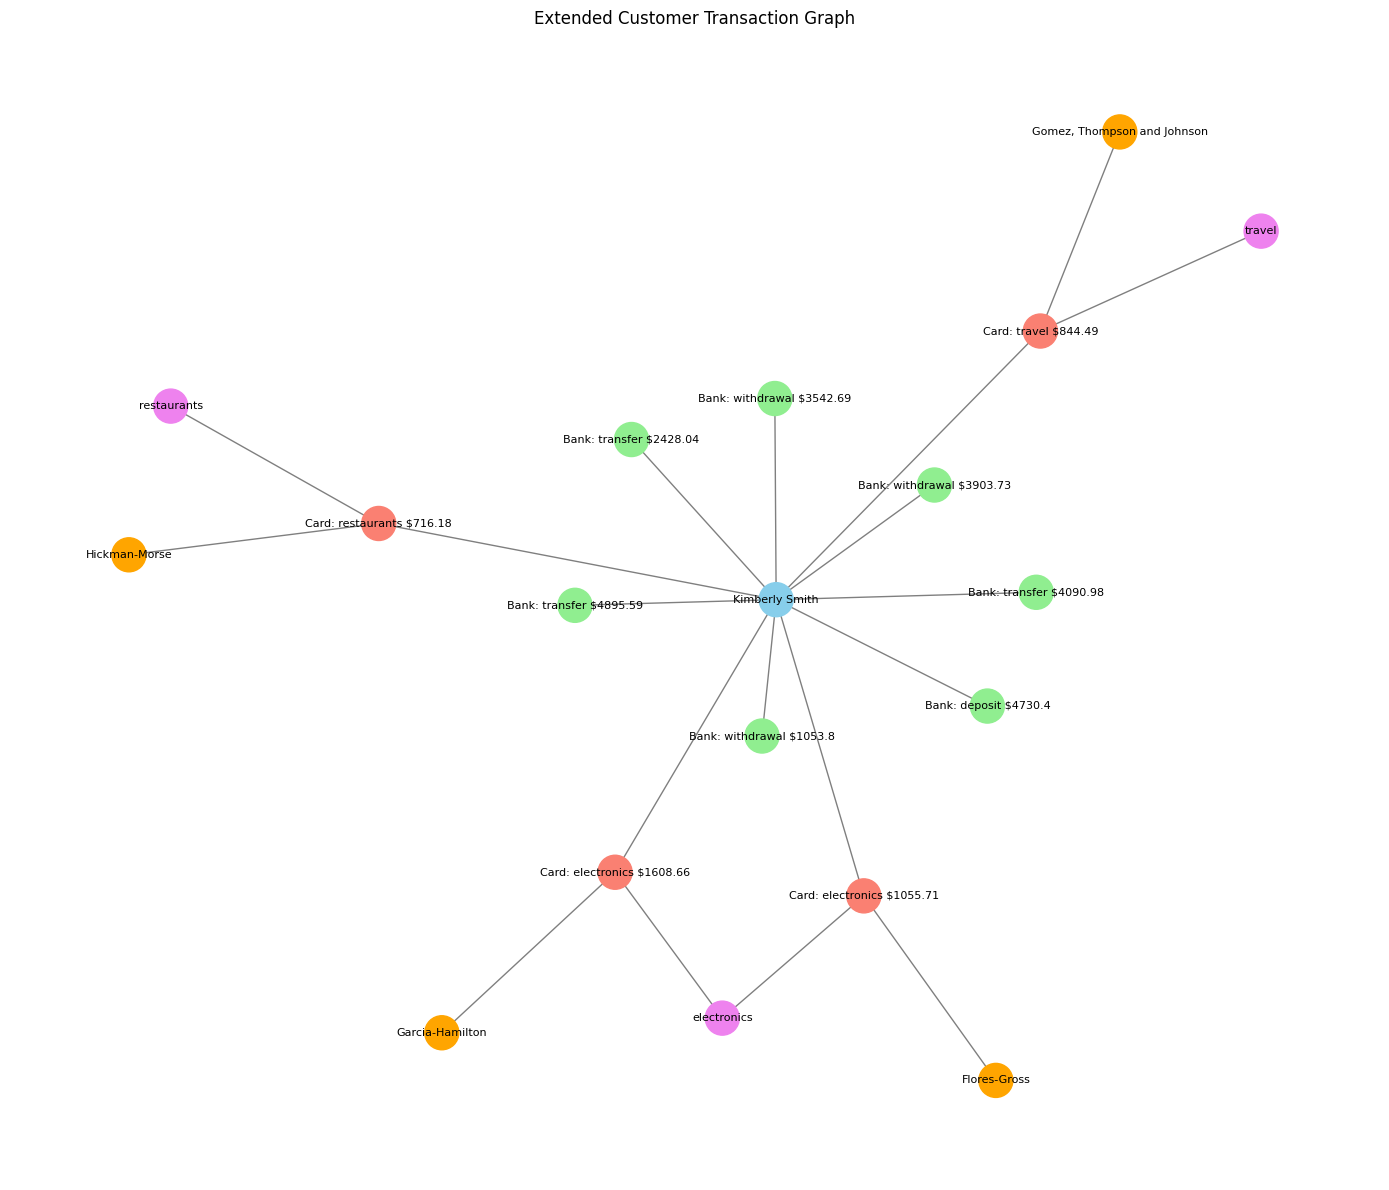

In [140]:

# Create graph
G = nx.Graph()

# print(graph_result)
customer_data = graph_result[0]

# Add customer node
customer_id = customer_data["customer_id"]
G.add_node(customer_id, label=customer_data["name"], type="customer")

# Add credit card transactions and merchant/category/offer nodes
for tx in customer_data["related_credit_card_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Card: {tx['category']} ${tx['amount']}"
    merchant = tx["merchant"]
    category = tx["category"]
    # offer = customer_data["offers"].get(category, "No offer")

    # Transaction node
    G.add_node(tx_id, label=tx_label, type="credit_card_tx")
    G.add_edge(customer_id, tx_id)

    # Merchant node
    G.add_node(merchant, label=merchant, type="merchant")
    G.add_edge(tx_id, merchant)

    # Category node
    G.add_node(category, label=category, type="category")
    G.add_edge(tx_id, category)

    # Offer node
    # G.add_node(offer, label=offer, type="offer")
    # G.add_edge(category, offer)

# Add bank transactions
for tx in customer_data["related_bank_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Bank: {tx['type']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="bank_tx")
    G.add_edge(customer_id, tx_id)

# Draw graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)

# Assign colors based on node type
node_colors = []
for node, data in G.nodes(data=True):
    if data["type"] == "customer":
        node_colors.append("skyblue")
    elif data["type"] == "bank_tx":
        node_colors.append("lightgreen")
    elif data["type"] == "credit_card_tx":
        node_colors.append("salmon")
    elif data["type"] == "merchant":
        node_colors.append("orange")
    elif data["type"] == "category":
        node_colors.append("violet")
    elif data["type"] == "offer":
        node_colors.append("gold")
    else:
        node_colors.append("gray")

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
labels = {node: data["label"] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Extended Customer Transaction Graph")
plt.axis("off")
plt.tight_layout()
plt.show()

## Customer Segmentation - Power BI-style dashboards using matplotlib and seaborn.
### Mongo vCore can be integrated to Power BI for generating such dashboards.

C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\3206164743.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_summary["total_spending"].fillna(0, inplace=True)


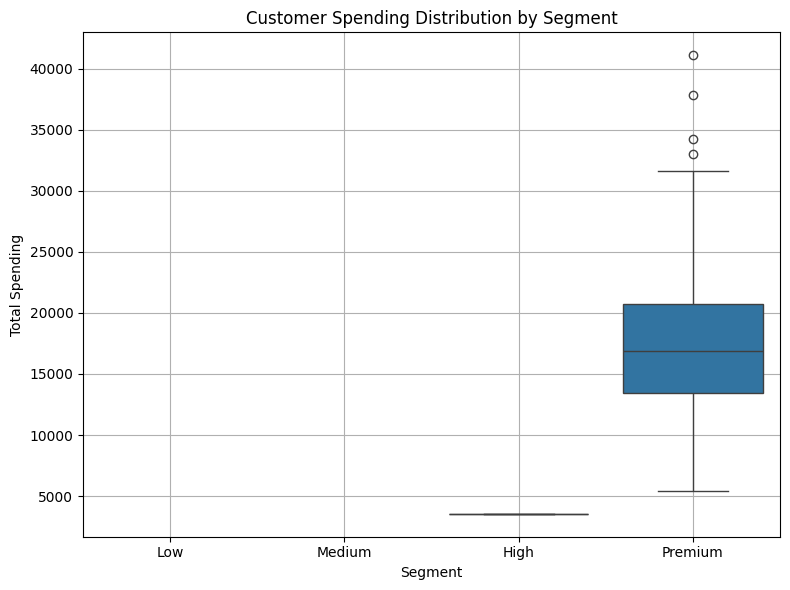

C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\3206164743.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="segment", data=customer_summary, order=["Low", "Medium", "High", "Premium"], palette="Set2")


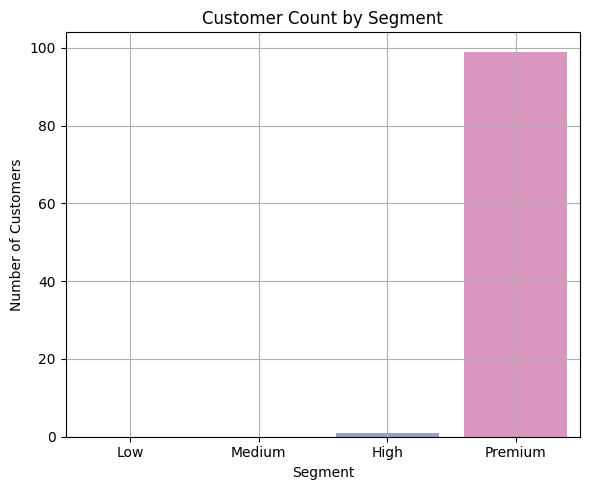

C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\3206164743.py:58: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")
C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\3206164743.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")


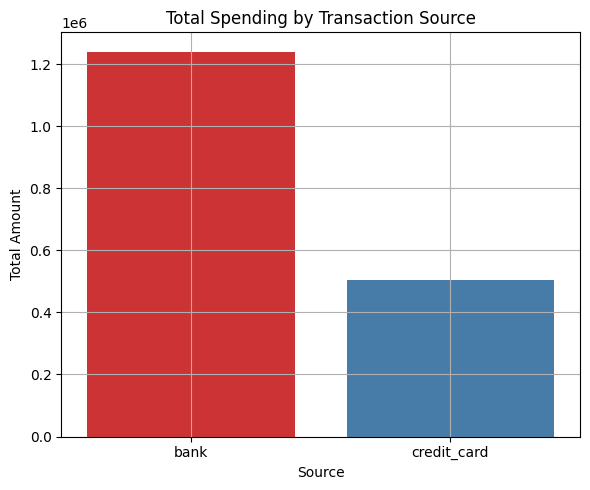

In [141]:
# Load data from MongoDB collections
customers_df = pd.DataFrame(list(db.customers.find()))
bank_tx_df = pd.DataFrame(list(db.customer_bank_trans.find()))
cc_tx_df = pd.DataFrame(list(db.customer_card_trans.find()))

# Drop MongoDB internal _id field
for df in [customers_df, bank_tx_df, cc_tx_df]:
    df.drop(columns=["_id"], inplace=True, errors="ignore")

# Combine bank and credit card transactions
bank_tx_df["source"] = "bank"
cc_tx_df["source"] = "credit_card"
combined_tx_df = pd.concat([bank_tx_df, cc_tx_df], ignore_index=True)

# Calculate total spending per customer
spending_summary = combined_tx_df.groupby("customer_id")["amount"].sum().reset_index()
spending_summary.rename(columns={"amount": "total_spending"}, inplace=True)

# Merge with customer profiles
customer_summary = pd.merge(customers_df, spending_summary, on="customer_id", how="left")
customer_summary["total_spending"].fillna(0, inplace=True)

# Segment customers based on total spending
def segment_customer(spending):
    if spending < 500:
        return "Low"
    elif spending < 2000:
        return "Medium"
    elif spending < 5000:
        return "High"
    else:
        return "Premium"

customer_summary["segment"] = customer_summary["total_spending"].apply(segment_customer)

# Plot 1: Spending distribution by segment
plt.figure(figsize=(8, 6))
sns.boxplot(x="segment", y="total_spending", data=customer_summary, order=["Low", "Medium", "High", "Premium"])
plt.title("Customer Spending Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Spending")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Count of customers by segment
plt.figure(figsize=(6, 5))
sns.countplot(x="segment", data=customer_summary, order=["Low", "Medium", "High", "Premium"], palette="Set2")
plt.title("Customer Count by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Total spending by transaction source
plt.figure(figsize=(6, 5))
sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")
plt.title("Total Spending by Transaction Source")
plt.xlabel("Source")
plt.ylabel("Total Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

## Implement Retrieval-Augmented Generation (RAG)

In [142]:
import openai
import numpy as np
from pymongo import MongoClient

# Step 1: Configure Azure OpenAI
openai.api_type = "azure"
openai.api_key = config['OPENAI_API_KEY']
openai.api_base = config['OPENAI_API_ENDPOINT']
openai.api_version = "2023-05-15"
embedding_model = config['OPENAI_EMBEDDINGS_DEPLOYMENT']

# Step 2: Connect to MongoDB
client = MongoClient(connection_string)
db = client[db_name]

# Step 3: Read data from collections
customer_profiles = list(db["customers"].find().limit(10))
db["customer_embeddings"].drop()

# Step 4: Embed and store documents
def embed_and_store(text, metadata):
    response = openai.embeddings.create(
        input=[text],
        model=embedding_model
    )
    embedding = response.data[0].embedding
    doc = {
        "text": text,
        "embedding": embedding,
        "metadata": metadata
    }
    db["customer_embeddings"].insert_one(doc)



# Step 5: Process each customer and their transactions
for customer in customer_profiles:
    customer_id = customer.get("customer_id")

    # Embed customer profile
    profile_text = (
        f"Customer ID: {customer.get('customer_id')}; "
        f"Name: {customer.get('name')}; "
        f"Email: {customer.get('email')}; "
        f"Phone: {customer.get('phone')}; "
        f"Address: {customer.get('address')}; "
        f"Date of Birth: {customer.get('dob')}; "
        f"Account Open Date: {customer.get('account_open_date')}"
    )
    embed_and_store(profile_text, {"type": "customer_profile", "customer_id": customer_id})

    # Embed bank transactions
    bank_transactions = list(db["customer_bank_trans"].find({"customer_id": customer_id}))
    for txn in bank_transactions:
        txn_text = (
            f"Bank Transaction ID: {txn.get('transaction_id')}; "
            f"Customer ID: {txn.get('customer_id')}; "
            f"Date: {txn.get('date')}; "
            f"Type: {txn.get('type')}; "
            f"Amount: {txn.get('amount')}; "
            f"Description: {txn.get('description')}"
        )
        embed_and_store(txn_text, {"type": "bank_transaction", "customer_id": customer_id})

    # Embed credit card transactions
    credit_card_transactions = list(db["customer_card_trans"].find({"customer_id": customer_id}))
    for cc_txn in credit_card_transactions:
        cc_text = (
            f"Credit Card Transaction ID: {cc_txn.get('transaction_id')}; "
            f"Customer ID: {cc_txn.get('customer_id')}; "
            f"Date: {cc_txn.get('date')}; "
            f"Merchant: {cc_txn.get('merchant')}; "
            f"Category: {cc_txn.get('category')}; "
            f"Amount: {cc_txn.get('amount')}; "
            f"Description: {cc_txn.get('description')}"
        )
        embed_and_store(cc_text, {"type": "credit_card_transaction", "customer_id": customer_id})


# Step 5: Semantic search

def semantic_search(query, top_k=3):
    query_embedding = openai.embeddings.create(
        input=[query],
        model=embedding_model
    ).data[0].embedding

    results = []
    for doc in db["customer_embeddings"].find():
        doc_embedding = np.array(doc["embedding"])
        similarity = np.dot(query_embedding, doc_embedding) / (
            np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding)
        )
        results.append((similarity, doc["text"]))
    results.sort(reverse=True, key=lambda x: x[0])
    return results[:top_k]

# Step 6: Sample RAG queries
sample_queries = [
    "Which customers have frequent withdrawals?",
    "Find customers with high-value transactions across both bank and credit card",
    "Which customers have unusual transaction description?",
    "Find credit card transactions in the groceries category.",
    "Who are the customers with consistent spending patterns?"
]

# Step 7: Run queries
for query in sample_queries:
    print(f"\nQuery: {query}")
    results = semantic_search(query)
    for score, text in results:
        print(f"Score: {score:.4f} | Text: {text}")


C:\Users\srisridh\AppData\Local\Temp\ipykernel_31320\1919440049.py:13: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(connection_string)
c:\FY26_IPs\C360\.venv\Lib\site-packages\pymongo\synchronous\mongo_client.py:1752: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  self._resolve_srv()



Query: Which customers have frequent withdrawals?
Score: 0.8123 | Text: Bank Transaction ID: B10471; Customer ID: C1001; Date: 2024-05-25; Type: withdrawal; Amount: 1053.8; Description: Treatment challenge vote maintain suddenly eight clear.
Score: 0.8111 | Text: Bank Transaction ID: B10150; Customer ID: C1001; Date: 2025-04-01; Type: withdrawal; Amount: 3542.69; Description: Speak answer fill on program others sort.
Score: 0.8094 | Text: Bank Transaction ID: B10172; Customer ID: C1008; Date: 2024-06-03; Type: withdrawal; Amount: 4306.42; Description: Medical science mind through as.

Query: Find customers with high-value transactions across both bank and credit card
Score: 0.8170 | Text: Credit Card Transaction ID: CC20379; Customer ID: C1007; Date: 2024-06-23; Merchant: Middleton Group; Category: electronics; Amount: 1943.32; Description: Huge this many term reflect.
Score: 0.8150 | Text: Credit Card Transaction ID: CC20487; Customer ID: C1005; Date: 2025-04-19; Merchant: Nelson-Hen